# Model Selection Using RFE : Recursive Feature Analysis

In [1]:
import pandas as pd
import numpy as np

In [2]:
#importing housing data 
housing=pd.read_csv('Housing.csv')

In [3]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


# Data Preparation

In [4]:
#converting yes to 1 and No to 0
housing['mainroad']=housing['mainroad'].map({'yes':1, "no":0})
housing['guestroom']=housing['guestroom'].map({'yes':1, "no":0})
housing['basement']=housing['basement'].map({'yes':1, 'no':0})
housing['hotwaterheating']=housing['hotwaterheating'].map({'yes':1, 'no':0})
housing['airconditioning']=housing['airconditioning'].map({'yes':1, 'no':0})
housing['prefarea']=housing['prefarea'].map({'yes':1, 'no':0})

In [5]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [6]:
#creating dummy varibale for furnishingstatus and dropping the first column
status=pd.get_dummies(['furnishingstatus'],drop_first=True)


In [7]:
#adding the result to the master dataframe
housing=pd.concat([housing,status], axis=1)


In [8]:
#dropping the variable furnishingstatsus
housing.drop(['furnishingstatus'],axis=1,inplace=True)

In [9]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea
0,13300000,7420,4,2,3,1,0,0,0,1,2,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0


# Creating New Variable

In [11]:
#let us create new variable and assign it to areaperbedroom
housing['areaperbedroom']=housing['area']/housing['bedrooms']

In [16]:
#metric : bathroom per bedroom
housing['bbratio']=housing['bathrooms']/housing['bedrooms']

housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,areaperbedroom,bbratio
0,-1.749999e+06,-1649.643827,-0.500000,-0.75,-0.50,1.0,0.0,0.0,0.0,1.0,0.666667,1.0,-380.776667,1.500
1,-1.749999e+06,-1649.548765,-0.500000,-0.25,-0.25,1.0,0.0,0.0,0.0,1.0,1.000000,0.0,-380.718333,0.500
2,-1.749999e+06,-1649.487037,-0.666667,-0.75,-0.75,1.0,0.0,1.0,0.0,0.0,0.666667,1.0,-380.554697,1.125
3,-1.749999e+06,-1649.638889,-0.500000,-0.75,-0.75,1.0,0.0,1.0,0.0,1.0,1.000000,1.0,-380.773636,1.500
4,-1.749999e+06,-1649.643827,-0.500000,-1.00,-0.75,1.0,1.0,1.0,0.0,1.0,0.666667,0.0,-380.776667,2.000


# ReScaling the feature

It is extremely important to rescale the variable so that they have comparable scale. There are two ways:
    1. Normalization (min-max scaling)
    2. Standardization
Let us try Normalization.

In [14]:
def normalize(x):
    return((x-np.min(x))/max(x)-min(x))
#applying normalization to all columns
housing=housing.apply(normalize)

# Splitting the data into training and test set

In [18]:
X = housing[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 
       'areaperbedroom', 'bbratio']]

# Putting response variable to y
y = housing['price']

In [30]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)


In [31]:
#UDF for calculating vif values
#VIF values are used for multi variables to determine the correlation among the varible
def vif_cal(input_data,dependent_col):
    vif_df=pd.DataFrame(columns=['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col],axis=1)
    xvar_names=x_vars.columns
    for i in range (0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]]
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)
        

# RFE

In [32]:
#Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


In [34]:
# Running RFE with the output number of the variable equal to 9
lm = LinearRegression()
rfe = RFE(lm, 9)             # running RFE
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)  

[ True  True  True  True  True False False  True  True False  True  True
 False]
[1 1 1 1 1 5 3 1 1 2 1 1 4]


In [35]:
col=X_train.columns[rfe.support_]

# Building Model using Sklearn

In [36]:
#creating x_test dataframe with RFE selected variables
X_train_rfe=X_train[col]

In [37]:
#adding a constant variable
import statsmodels.api as sm
X_train_rfe=sm.add_constant(X_train_rfe)

In [38]:
#running the linear model
lm=sm.OLS(y_train,X_train_rfe).fit()

In [39]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     80.01
Date:                Wed, 31 Jul 2019   Prob (F-statistic):           2.28e-81
Time:                        18:50:18   Log-Likelihood:                 423.09
No. Observations:                 381   AIC:                            -826.2
Df Residuals:                     371   BIC:                            -786.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.749e+06    146.644  -1.

In [42]:
#calculating vif values
vif_cal(input_data=housing.drop(['area','bedrooms','stories','basement','areaperbedroom'],axis=1), dependent_col="price")


,Var,Vif
0,bathrooms,19.94
7,bbratio,15.88
1,mainroad,7.21
5,parking,1.77
4,airconditioning,1.56
6,prefarea,1.41
2,guestroom,1.27
3,hotwaterheating,1.07


# Making Predictions

In [43]:
#now let us use our model to make prediction

#creating X_test_rfe dataframe by dropping variables from X_test
X_test_rfe=X_test[col]

#adding a constant variable
X_test_rfe=sm.add_constant(X_test_rfe)

#making prediction
y_pred=lm.predict(X_test_rfe)

# Model Evaluation

In [44]:
#let us see how well our model is able to make prediction
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0, 0.5, 'Housing Price')

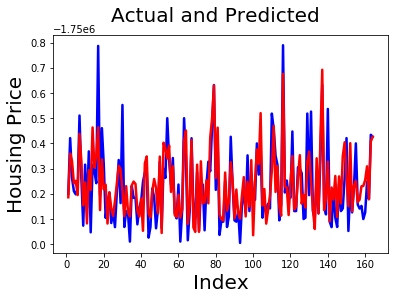

In [46]:
#actual and predicted
import matplotlib.pyplot as plt
c=[i for i in range (1,165,1)] #generating index
fig=plt.figure()
plt.plot(c,y_test,color="blue",linewidth=2.5, linestyle="-")
plt.plot(c,y_pred,color="red",linewidth=2.5,linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)
plt.xlabel('Index',fontsize=20)
plt.ylabel("Housing Price", fontsize=20)

Text(0, 0.5, 'ytest-ypred')

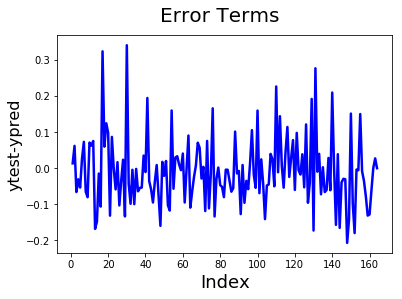

In [47]:
#error terms
c=[i for i in range (1,165,1)] #generating index
fig=plt.figure()
plt.plot(c,y_test-y_pred,color="blue",linewidth=2.5,linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label


Text(0, 0.5, 'y_pred')

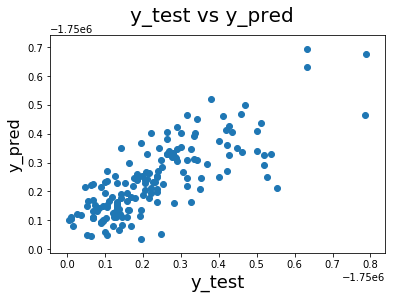

In [48]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

C:\Users\Saurabh Anand\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Index')

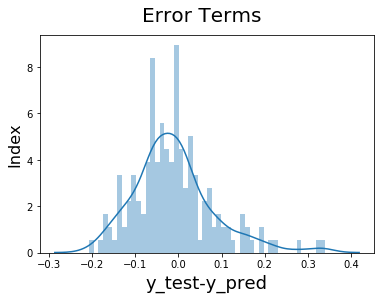

In [49]:
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label

In [50]:
#now let us check the root mean square error of our model
import numpy as np
from sklearn import metrics
print('RMSE: ',np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

RMSE:  0.09384207042337527
